In [26]:
import tensorflow as tf

from tensorflow import keras
from keras import datasets, layers, models
from keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
from pathlib import Path


tf.config.optimizer.set_jit(True)

In [27]:
batch_size = 32
img_height = 180
img_width = 180
processed_datasets_directory = "data_working"

In [28]:
train_dir = Path(processed_datasets_directory + "/train")
validate_dir = Path(processed_datasets_directory + "/validate")


def fetch_datasets(folder_name):
  print("\nFetching datasets in:", folder_name)
  datasets = {}
  for source in Path(processed_datasets_directory + "/" + folder_name).glob("*"):
    datasets[source.name] = tf.keras.utils.image_dataset_from_directory(
      source,
      image_size=(img_height, img_width),
      batch_size=batch_size
    )
  return datasets

test_datasets = fetch_datasets("test")
print("Fetching validation dataset")
validate_ds = tf.keras.utils.image_dataset_from_directory(
  validate_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
print("Fetching training dataset")
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


Fetching datasets in: test
Found 400 files belonging to 4 classes.
Found 12 files belonging to 4 classes.
Found 3924 files belonging to 4 classes.
Found 2100 files belonging to 4 classes.
Found 188 files belonging to 4 classes.
Found 268 files belonging to 4 classes.
Found 288 files belonging to 4 classes.
Found 180 files belonging to 4 classes.
Found 232 files belonging to 4 classes.
Found 172 files belonging to 4 classes.
Found 240 files belonging to 4 classes.
Found 208 files belonging to 4 classes.
Found 180 files belonging to 4 classes.
Found 160 files belonging to 4 classes.
Found 64 files belonging to 4 classes.
Found 240 files belonging to 4 classes.
Found 168 files belonging to 4 classes.
Found 1192 files belonging to 4 classes.
Found 1116 files belonging to 4 classes.
Found 180 files belonging to 4 classes.
Fetching validation dataset
Found 23108 files belonging to 4 classes.
Fetching training dataset
Found 81044 files belonging to 4 classes.


['0', '180', '270', '90']


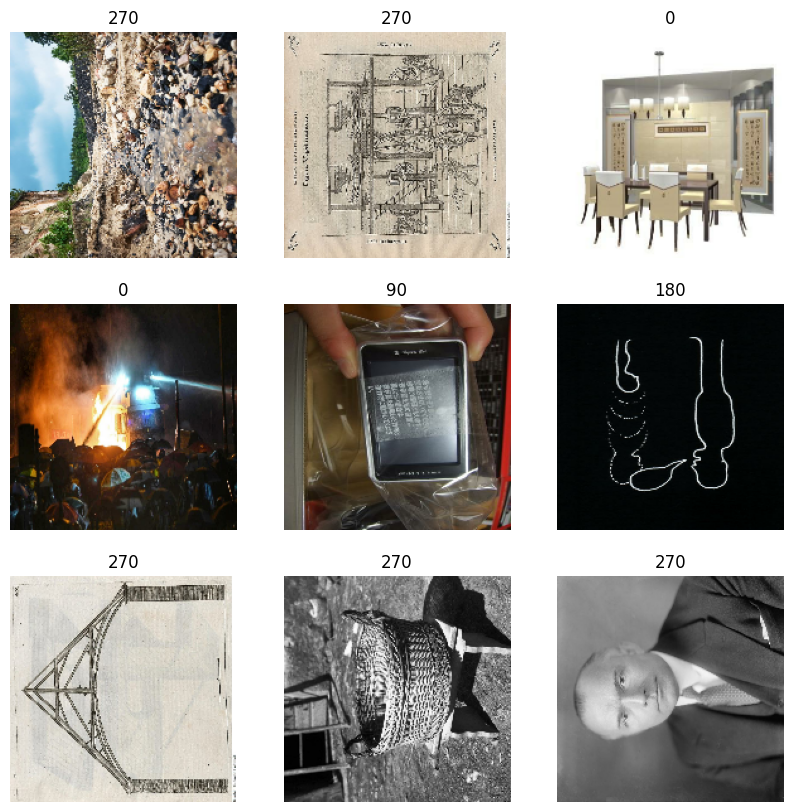

In [29]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

(32, 180, 180, 3)
(32,)
0.0 0.8779215


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_cached = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validate_ds_cached = validate_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [32]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [17]:
# Param search
from tensorboard.plugins.hparams import api as hp

HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['relu', 'sigmoid']))
HP_NUM_CONV_LAYERS = hp.HParam('num_conv_layers', hp.Discrete([3]))
HP_CONV_KERNEL_SIZE = hp.HParam('conv_kernel_size', hp.Discrete([3]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
HP_NUM_DENSE_UNITS = hp.HParam('num_dense_units', hp.Discrete([64,128,256])) 
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_OPTIMIZER, HP_ACTIVATION, HP_NUM_CONV_LAYERS, HP_CONV_KERNEL_SIZE, HP_DROPOUT, HP_NUM_DENSE_UNITS],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [18]:
num_classes = len(class_names)

def tune_model(params):
  model_layers = [
    # data_augmentation,
    layers.Rescaling(1./255)
  ]

  output_filters = 16
  for i in range(params[HP_NUM_CONV_LAYERS]):
    model_layers.append(layers.Conv2D(output_filters, params[HP_CONV_KERNEL_SIZE], padding='same', activation=params[HP_ACTIVATION]))
    model_layers.append(layers.MaxPooling2D())  
    output_filters = output_filters * 2

  model_layers.append(layers.Dropout(params[HP_DROPOUT]))
  model_layers.append(layers.Flatten())
  model_layers.append(layers.Dense(params[HP_NUM_DENSE_UNITS], activation=params[HP_ACTIVATION]))
  model_layers.append(layers.Dense(num_classes, name="outputs"))

  model = Sequential(model_layers)
  model.compile(optimizer=params[HP_OPTIMIZER],
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  # print(model.summary())

  epochs=2
  history = model.fit(
    train_ds_cached,
    validation_data=validate_ds_cached,
    # validation_split=0.3,
    epochs=epochs
  )
  return history.history['val_accuracy'][0]
  # return 0
  # return val_acc

In [19]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = tune_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [20]:
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
# HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['relu', 'sigmoid']))
# HP_NUM_CONV_LAYERS = hp.HParam('num_conv_layers', hp.Discrete([1,2,3,4]))
# HP_CONV_KERNEL_SIZE = hp.HParam('conv_kernel_size', hp.Discrete([3,4,5]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
# HP_NUM_DENSE_UNITS = hp.HParam('num_dense_units', hp.Discrete([16,32,64,128,256,512])) 
# HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))

session_num = 0
for optimizer in HP_OPTIMIZER.domain.values:
  for activation in HP_ACTIVATION.domain.values:
    for conv_layers in HP_NUM_CONV_LAYERS.domain.values:
      for kernel_size in HP_CONV_KERNEL_SIZE.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
          for dense_units in HP_NUM_DENSE_UNITS.domain.values:  
            hparams = {
                HP_OPTIMIZER: optimizer,
                HP_ACTIVATION: activation,
                HP_NUM_CONV_LAYERS: conv_layers,
                HP_CONV_KERNEL_SIZE: kernel_size,
                HP_DROPOUT: dropout_rate,
                HP_NUM_DENSE_UNITS: dense_units,
                HP_OPTIMIZER: optimizer 
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'optimizer': 'adam', 'activation': 'relu', 'num_conv_layers': 3, 'conv_kernel_size': 3, 'dropout': 0.2, 'num_dense_units': 64}
Epoch 1/2
155/155 [==============================] - 54s 344ms/step - loss: 1.3579 - accuracy: 0.3493 - val_loss: 1.3479 - val_accuracy: 0.4175
Epoch 2/2
155/155 [==============================] - 49s 314ms/step - loss: 1.2602 - accuracy: 0.4411 - val_loss: 1.2858 - val_accuracy: 0.4650
--- Starting trial: run-1
{'optimizer': 'adam', 'activation': 'relu', 'num_conv_layers': 3, 'conv_kernel_size': 3, 'dropout': 0.2, 'num_dense_units': 128}
Epoch 1/2
155/155 [==============================] - 51s 326ms/step - loss: 1.4126 - accuracy: 0.3200 - val_loss: 1.2876 - val_accuracy: 0.4588
Epoch 2/2
155/155 [==============================] - 53s 343ms/step - loss: 1.2610 - accuracy: 0.4523 - val_loss: 1.2586 - val_accuracy: 0.4550
--- Starting trial: run-2
{'optimizer': 'adam', 'activation': 'relu', 'num_conv_layers': 3, 'conv_kernel_size': 3, 

In [21]:
%tensorboard --logdir logs/hparam_tuning

UsageError: Line magic function `%tensorboard` not found.


In [33]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [36]:
path_checkpoint = "checkpoint/cp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)

callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                                 # save_weights_only=True,
                                                 verbose=1)

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_28 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_75 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [39]:
epochs=10
history = model.fit(
  train_ds_cached,
  validation_data=validate_ds_cached,
  callbacks=[callback],
  epochs=epochs
)

Epoch 1/10
 737/2533 [=======>......................] - ETA: 14:55 - loss: 1.2911 - accuracy: 0.4029

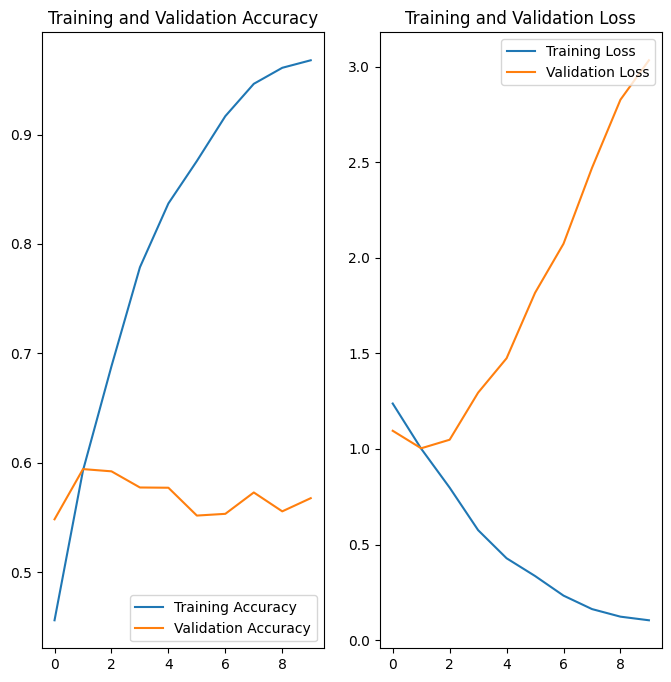

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## References
 - https://www.tensorflow.org/tutorials/load_data/images
 